In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error, r2_score,explained_variance_score


# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm



In [6]:
df = pd.read_excel("finaldata.xlsx")

In [7]:
df.drop_duplicates(subset=['TimeStamp'])

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.280,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.180,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.910,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,65.160,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,65.160,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,367.16,0.0931,116.3,456.0,146.4,96.5,1658.4,15.8,73.0,245.195,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,311.32,0.0751,92.3,450.7,123.8,93.6,1678.3,14.5,80.0,245.195,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,290.98,0.0668,80.5,450.7,122.2,93.6,1649.8,14.0,77.0,228.590,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,309.83,0.0732,59.7,340.1,121.5,96.1,1630.2,13.3,82.0,228.590,29,6,22,2


In [8]:
data=df.copy()
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('TimeStamp')
data = data.asfreq('H')
data = data.sort_index()
data.head(2)

,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
TimeStamp,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1.0,1.0,0.0,1.0
2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1.0,1.0,1.0,1.0


In [9]:
data=data.fillna(method='ffill')
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)
data['IE Demand'] = data['IE Demand'].fillna(0)

In [10]:
data=data.drop(data[data.index>pd.to_datetime('31-12-2021  23:00:00')].index)
data.shape

(26304, 16)

In [11]:
min_date = data.index.min()
max_date = data.index.max()
print("Min:", min_date, "Max:", max_date)
train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Min: 2019-01-01 00:00:00 Max: 2021-12-31 23:00:00


Timestamp('2021-05-26 18:24:00', freq='H')

In [12]:
train_df = data[data.index <= train_cutoff]
test_df = data[data.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Train: 2019-01-01 00:00:00 2021-05-26 18:00:00 21043
Test: 2021-05-26 19:00:00 2021-12-31 23:00:00 5261


In [13]:
train_df=train_df.drop(columns=['ElectricityPrice'])
test_df=test_df.drop(columns=['ElectricityPrice'])

In [14]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features.remove('IE Demand')
exogenous_features

['IE Generation',
 'IE Wind Generation',
 'SNSP',
 'Hydro Run-of-River',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil peat',
 'Fossil gas',
 'temp',
 'rhum',
 'day',
 'month',
 'hour',
 'dayofweek']

In [15]:
# Define p, d, q params to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate all different combos of seasonal P, D, Q
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [16]:
warnings.filterwarnings("ignore")


min_aic = float('inf')
min_params = None
min_params_seasonal = None
min_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                train_df['IE Demand'],
                exog=train_df.loc[:, train_df.columns != 'IE Demand'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                min_params = param
                min_params_seasonal = param_seasonal
                min_model = results
            print('ARIMA{}x{}: aic={}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7): aic=284641.18981958425
ARIMA(0, 0, 0)x(0, 0, 1, 7): aic=282728.9064397681
ARIMA(0, 0, 0)x(0, 1, 0, 7): aic=289672.22834448586
ARIMA(0, 0, 0)x(0, 1, 1, 7): aic=281262.86693977925
ARIMA(0, 0, 0)x(1, 0, 0, 7): aic=282599.25672568835
ARIMA(0, 0, 0)x(1, 0, 1, 7): aic=281247.9132953831
ARIMA(0, 0, 0)x(1, 1, 0, 7): aic=285811.73837151984
ARIMA(0, 0, 0)x(1, 1, 1, 7): aic=280713.7691671324
ARIMA(0, 0, 1)x(0, 0, 0, 7): aic=269574.39368674136
ARIMA(0, 0, 1)x(0, 0, 1, 7): aic=269253.4237414199
ARIMA(0, 0, 1)x(0, 1, 0, 7): aic=276515.7643846503
ARIMA(0, 0, 1)x(0, 1, 1, 7): aic=269291.35761512583
ARIMA(0, 0, 1)x(1, 0, 0, 7): aic=269215.885389468
ARIMA(0, 0, 1)x(1, 0, 1, 7): aic=268766.2600869663
ARIMA(0, 0, 1)x(1, 1, 0, 7): aic=273185.9748554435
ARIMA(0, 0, 1)x(1, 1, 1, 7): aic=269264.24798638036
ARIMA(0, 1, 0)x(0, 0, 0, 7): aic=252859.3152737359
ARIMA(0, 1, 0)x(0, 0, 1, 7): aic=252358.43141756326
ARIMA(0, 1, 0)x(0, 1, 0, 7): aic=269035.9995253885
ARIMA(0, 1, 0)x(0, 1, 1

In [17]:
print('min_aic={}, min_params={}, min_params_seasonal={}'.format(min_aic, min_params, min_params_seasonal))

min_aic=250160.57824056197, min_params=(1, 1, 1), min_params_seasonal=(0, 0, 1, 7)


In [18]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [19]:
from skforecast.utils import save_forecaster

In [20]:
save_forecaster(min_model, file_name='demandSarima2.py', verbose=False)

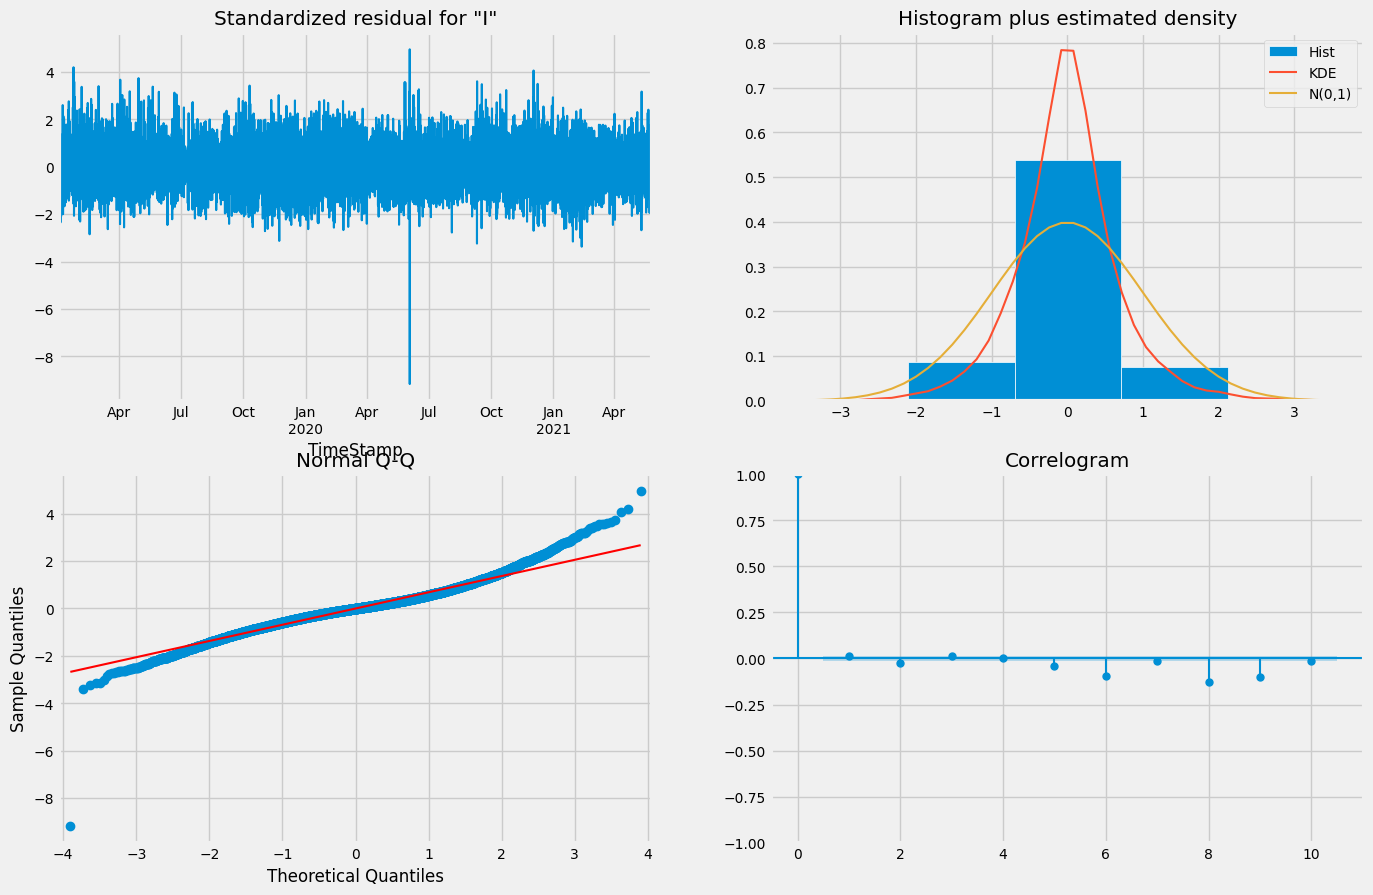

In [21]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         IE Demand   No. Observations:                21043
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood             -127548.939
Date:                           Fri, 30 Jun 2023   AIC                         255135.878
Time:                                   13:49:22   BIC                         255286.995
Sample:                               01-01-2019   HQIC                        255185.199
                                    - 05-26-2021                                         
Covariance Type:                             opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
IE Generation          0.8292      0.010     80.592      0.000       0.809       0.849
IE Wind Generation    -0.7474      0.018    -42.606      0.000      -0.782      -0.713
SNSP                3305.6425     60.751     54.413      0.000    3186.573    3424.712
Hydro Run-of-River     0.3937      0.112      3.529      0.000       0.175       0.612
Fossil hard coal       0.0863      0.052      1.668      0.095      -0.015       0.188
Fossil oil             0.0521      0.021      2.423      0.015       0.010       0.094
Fossil peat            0.3184      0.065      4.915      0.000       0.191       0.445
Fossil gas             0.0717      0.012      6.058      0.000       0.048       0.095
temp                  11.5083      1.984      5.800      0.000       7.620      15.397
rhum                   0.3814      0.340      1.121      0.262      -0.285       1.048
day                   -0.7958      0.873     -0.912      0.362      -2.506       0.914
month                -17.4085      7.024     -2.478      0.013     -31.176      -3.641
hour                   0.2960      0.213      1.391      0.164      -0.121       0.713
dayofweek             -1.7086      2.115     -0.808      0.419      -5.853       2.436
ar.L1                  0.4773      0.028     17.218      0.000       0.423       0.532
ma.L1                 -0.0124      0.029     -0.424      0.671      -0.070       0.045
ar.S.L7               -0.1591      0.015    -10.819      0.000      -0.188      -0.130
ma.S.L7               -0.9993      0.001   -749.115      0.000      -1.002      -0.997
sigma2              1.847e+04    220.491     83.773      0.000     1.8e+04    1.89e+04
===================================================================================
Ljung-Box (L1) (Q):                   4.77   Jarque-Bera (JB):             12692.27
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
steps = len(test_df)
pred = results.get_forecast(steps=steps, exog=test_df.loc[:, test_df.columns != 'IE Demand'])

In [23]:
y_test=test_df['IE Demand']
y_pred=pred.predicted_mean

In [25]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 379.8837007807292
MSE: 144311.62611886262
MAE: 295.28496008998
MAPE: 0.0963033446060327
Max Error: 1188.4000320071068
Explained Variance Score: 0.7768005102940807
R2Score: 0.6253487212981848


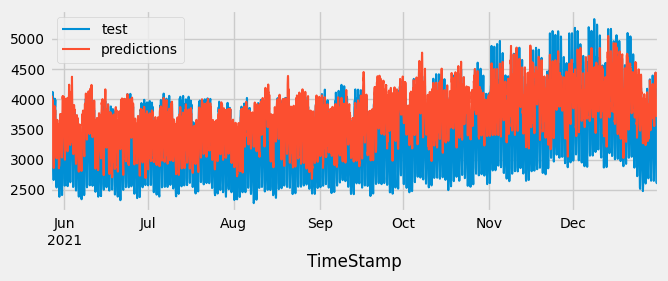

In [26]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [27]:
pred_data=df.copy()
pred_data['TimeStamp'] = pd.to_datetime(pred_data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [28]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data.shape

(4319, 17)

In [29]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data.shape

(145, 17)

In [30]:
pred_data=pred_data.drop(columns=['ElectricityPrice'])

In [31]:
pred_data = pred_data.set_index('TimeStamp')
pred_data = pred_data.asfreq('H')
pred_data = pred_data.sort_index()

In [ ]:
last_window = test_df['IE Demand'].tail(50)

In [59]:
start = test_df.index[0] #(=431)
end = test_df.index[-1] #(=721)

In [ ]:
exog = pred_data.loc[:, pred_data.columns != 'IE Demand']+pred_data.loc[:, pred_data.columns != 'IE Demand']

In [65]:
y_pred = results.forecast(steps=145, exog=pred_data.loc[:, pred_data.columns != 'IE Demand'])

In [33]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('20-12-2021  23:00:00')].index)

In [34]:
pred_ci = pred.conf_int()

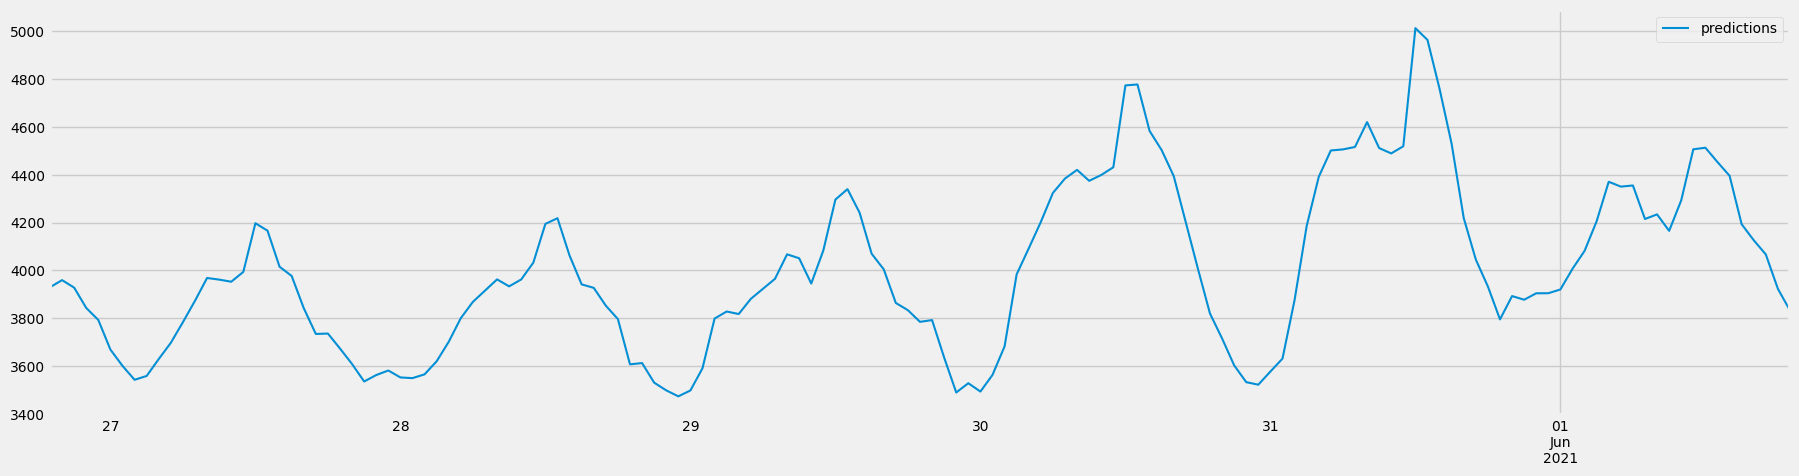

In [66]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
#plottest['IE Demand'].plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
#pred_ci.plot(ax=ax, label='confidence interval')
ax.legend();
plt.show()